You MUST run the following cell first in order for interactivity to work.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

The point of this notebook is to create an interactive plot, so the data chosen isn't particularly important. 1 sample will be collected from each of 4 different iid distributions, and a bar chart will be created where the height of each bar reflects the value of sample mean. The (approximated) 95% confidence intervals for each population mean will also be plotted.

In [2]:
import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])

Click class serves to distinguish between single click and click and drag actions. In the plot below, a single click
selects the y-value the mouse is currently above, plots the constant line for that value, and recolors the bars based on the probability the mean of the population means is greater than that y value. Clicking and dragging selects an interval and the recolors the bars based on the probability the population means are contained in that interval.

Probabilities are based on the assumption that the sample mean is normally distributed around the population mean (and not the prior knowledge that the population distributions are normal, since this would be unknown in most practical situations) and so are technically approximate, but should be accurate since n (=3650) is large.

In [3]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import sem
from scipy.stats import norm as norm

x=np.array(df.index)
df_means=df.apply(np.mean, axis=1)
df_ci_lengths=1.96*df.apply(sem, axis=1)
df_ci_u=list(df_means+df_ci_lengths)
df_ci_l=list(df_means-df_ci_lengths)

class Click:
    def __init__(self, ax, click_func, drag_func, button):
        self.ax=ax
        self.click_func=click_func # Function to call when clicked
        self.drag_func=drag_func # Function to call when clicked and dragged
        self.button=button # Button associated w/ click
        self.press=False # Flag for if button has been pressed
        self.move=False # Flag for if mouse has moved
        self.press_ydata=(0,0)

        # Connection for button press
        self.cid_press=plt.gcf().canvas.mpl_connect('button_press_event', self.on_press)
       
        # Connection for mouse movement
        self.cid_move=plt.gcf().canvas.mpl_connect('motion_notify_event', self.on_move)
        
        # Connection for button release
        self.cid_release=plt.gcf().canvas.mpl_connect('button_release_event', self.on_release)

    def on_press(self, event):
        if event.button == self.button and event.inaxes is ax:
            self.press=True # Button has been pressed
            self.press_ydata=event.ydata # Store y-value
    def on_move(self, event):
        if self.press: # If button pressed and has not been released...
            self.move=True # then record movement
    def on_release(self, event):
        if self.press and not self.move and event.inaxes is ax: # If button pressed and no movement...
            self.click_func(event) # then we register that as a click
        elif self.press and self.move and event.inaxes is ax: # If button pressed and movement...
            self.drag_func(event, self.press_ydata) # then we register that as select and drag
        self.press = self.move = False # Reset these flags for next button press

#def disconnect_Click(Click):
#    plt.gcf().canvas.mpl_disconnect(Click.cid_press)
#    plt.gcf().canvas.mpl_disconnect(Click.cid_move)
#    plt.gcf().canvas.mpl_disconnect(Click.cid_release)

def annotate_probability(bar_number, p):
    global anns_list
    anns_list.append(plt.gca().annotate('p = '+str(round(p,3)), [x[bar_number]+.5, 16000], rotation=90, ha='left'))
    

def on_click(event):
    
    global df
    global df_means
    global df_ci_lengths
    global bars
    global lines_list
    global anns_list
    global fill

    for i, l in enumerate(lines_list):
        l.remove()
    for i, a in enumerate(anns_list):
        a.remove()
    if fill is not None: plt.gca().collections.remove(fill)

    lines_list = []
    anns_list = []

    #print('Mouse clicked at y='+str(round(event.ydata,3)))
    #print('Probabilities y > population mean')
    for i in range(len(bars)):
        p=norm(df_means.iloc[i], df_ci_lengths.iloc[i]/1.96).cdf(event.ydata)
        bars[i].set_color((cmap.get_cmap())(p))
        annotate_probability(i, p)
        #print(str(df.index[i])+': '+str(np.round(p, 3)))

    plt.gca().set_title('Probability population means \nless than y='+str(round(event.ydata,3)))
    lines_list.append(plt.gca().plot([1992,1999], [event.ydata,event.ydata], color='black')[0])
    anns_list.append(plt.gca().annotate('y='+str(round(event.ydata,3)), [1995, event.ydata+300], fontsize=9))
    fill = None
    plt.gcf().canvas.draw()

def on_drag(event, press_y):

    global df
    global df_means
    global df_ci_lengths
    global bars
    global lines_list
    global anns_list
    global fill
    
    for i, l in enumerate(lines_list):
        l.remove()
    for i, a in enumerate(anns_list):
        a.remove()
    if fill is not None: plt.gca().collections.remove(fill)
    
    lines_list = []
    anns_list = []

    M=np.max([press_y, event.ydata])
    m=np.min([press_y, event.ydata])
    # print('Interval selected is I='+str([round(m,3), round(M,3)]))
    # print('Probabilities population means in I: ')
    for i in range(len(bars)):
        p=(
            norm(df_means.iloc[i], df_ci_lengths.iloc[i]/1.96).cdf(M) - 
            norm(df_means.iloc[i], df_ci_lengths.iloc[i]/1.96).cdf(m)
            )
        bars[i].set_color((cmap.get_cmap())(p))
        annotate_probability(i,p)
        #print(str(df.index[i])+': '+str(np.round(p,5)))

    plt.gca().set_title('Probability population means \nin interval [{},{}]'.format(str(round(m,3)),str(round(M,3))))
    lines_list.append(plt.gca().plot([1992,1999],[M,M], color='black')[0])
    lines_list.append(plt.gca().plot([1992,1999],[m,m], color='black')[0])
    anns_list.append(plt.gca().annotate('y='+str(round(M,3)), [1995, M+300], fontsize=9))
    anns_list.append(plt.gca().annotate('y='+str(round(m,3)), [1995, m-2000], fontsize=9))
    fill = plt.gca().fill_between(range(1991,1998), [m]*7, [M]*7, facecolor='grey', alpha=.3)
    plt.gcf().canvas.draw()

After running the above code, the following code produces the plot.

<IPython.core.display.Javascript object>


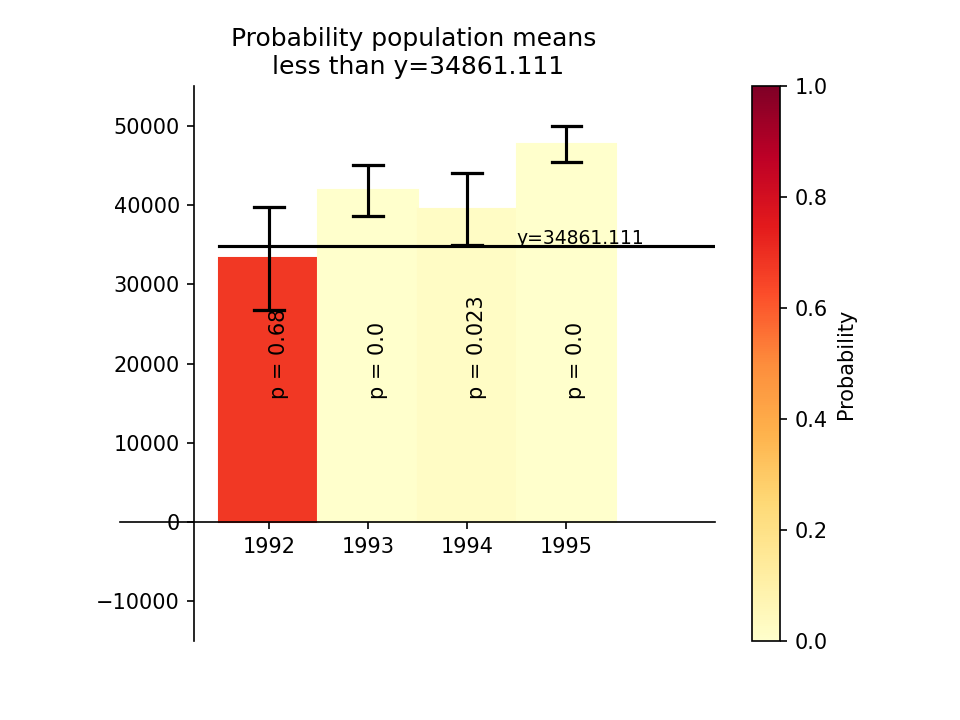

In [6]:
# plt.style.use('default')
fig, ax = plt.subplots()
bars=ax.bar(x, df_means, 
            width=1, align='edge', color=['#ea698b','#ac46a1','#6d23b6','#47126b'], 
            yerr=df_ci_lengths
            )

for i in range(len(x)):
    ax.lines.append(ax.plot([x[i]+.35,x[i]+.65], [df_ci_l[i]]*2, color='black')[0])
    ax.lines.append(ax.plot([x[i]+.35,x[i]+.65], [df_ci_u[i]]*2, color='black')[0])

ax.set_xticks(x+.5)
ax.set_xticklabels(['1992','1993','1994','1995'])
ax.set(xlim=(1991,1997), ylim=(-15000,55000))
ax.spines['left'].set_position(('data',1991.75))
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

cmap=cm.ScalarMappable(norm=mcolors.Normalize(0,1),
                       cmap=cm.get_cmap('YlOrRd'))
cmap.set_array([])
cbar = fig.colorbar(cmap, ax=ax)
cbar.set_label('Probability')

lines_list = []
anns_list = []
fill = None

click=Click(ax, on_click, on_drag, 1)
plt.show()
# disconnect_Click(click)